# Importing the libraries

In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy
from scipy import stats
from scipy.stats import norm
from scipy.stats import ttest_1samp
%matplotlib inline

# Loading and understanding data

In [2]:
# loading the file

data = pd.read_csv('sleepdata.csv', delimiter = ';')

In [3]:
# checking the shape of dataframe

data.shape

(270, 8)

In [4]:
# quick peek at the top 5 rows

data.head()

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
0,2013-03-10 11:41:32,2013-03-10 17:33:33,63%,5:52,NaN,NaN,NaN,0
1,2013-03-11 10:09:53,2013-03-11 17:49:49,82%,7:39,NaN,NaN,NaN,0
2,2013-03-12 10:35:15,2013-03-12 10:51:50,3%,0:16,NaN,NaN,NaN,0
3,2013-03-12 11:08:14,2013-03-12 11:24:05,3%,0:15,NaN,NaN,NaN,0
4,2013-03-12 11:24:19,2013-03-12 17:53:05,69%,6:28,NaN,NaN,NaN,0


In [5]:
# variables and their types

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 8 columns):
Start               270 non-null object
End                 270 non-null object
Sleep quality       270 non-null object
Time in bed         270 non-null object
Wake up             107 non-null object
Sleep Notes         108 non-null object
Heart rate          99 non-null float64
Activity (steps)    270 non-null int64
dtypes: float64(1), int64(1), object(6)
memory usage: 17.0+ KB


# Cleaning and Validation

In [6]:
# removing spaces from the column names

data.rename(
  columns={
    'Sleep quality' : 'Sleep_quality',
    'Time in bed' : 'Time_in_bed',
    'Wake up' : 'Wake_up',
    'Sleep Notes' : 'Sleep_Notes',
    'Heart rate' : 'Heart_rate',
    'Activity (steps)' : 'Activity_steps',  
  },
  inplace=True
)
data.head()

,Start,End,Sleep_quality,Time_in_bed,Wake_up,Sleep_Notes,Heart_rate,Activity_steps
0,2013-03-10 11:41:32,2013-03-10 17:33:33,63%,5:52,NaN,NaN,NaN,0
1,2013-03-11 10:09:53,2013-03-11 17:49:49,82%,7:39,NaN,NaN,NaN,0
2,2013-03-12 10:35:15,2013-03-12 10:51:50,3%,0:16,NaN,NaN,NaN,0
3,2013-03-12 11:08:14,2013-03-12 11:24:05,3%,0:15,NaN,NaN,NaN,0
4,2013-03-12 11:24:19,2013-03-12 17:53:05,69%,6:28,NaN,NaN,NaN,0


In [7]:
# removing unwanted columns

df = data.drop(columns = ['Wake_up'])
df.shape

(270, 7)

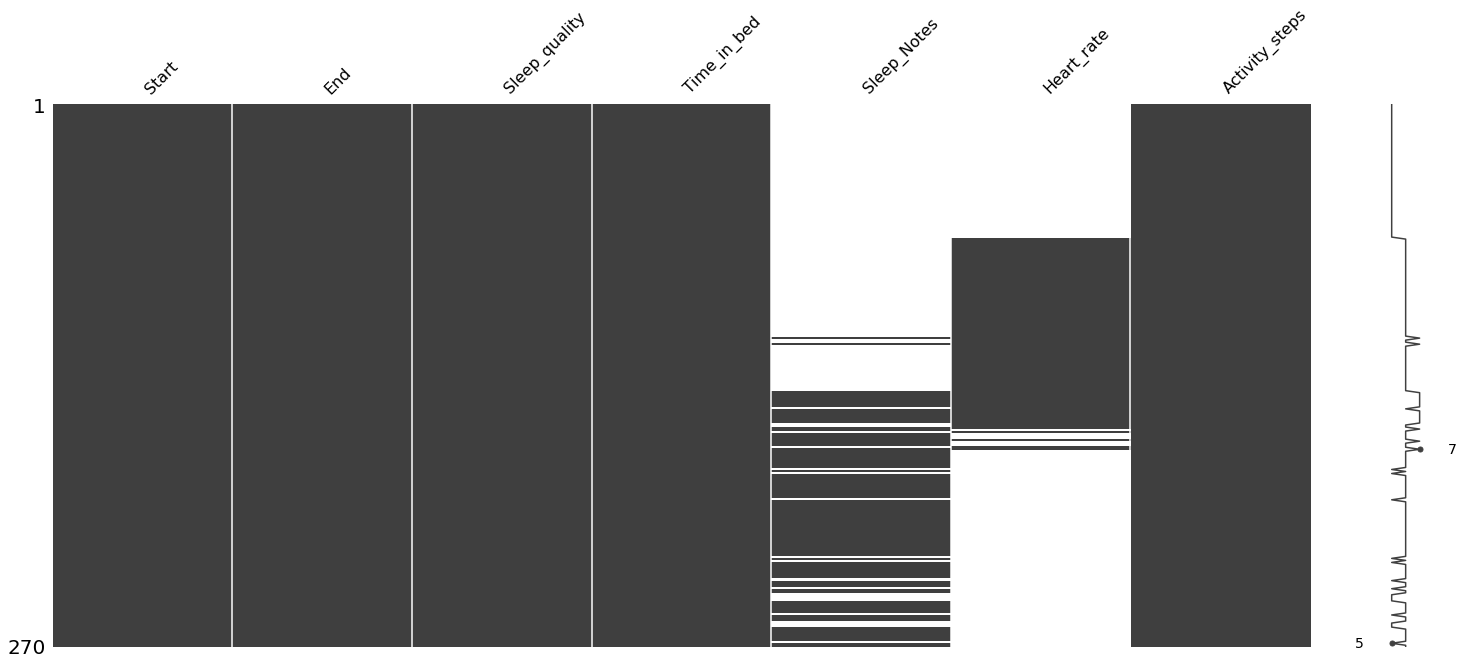

In [8]:
# cheking for missing data

msno.matrix(df);

# sleep_notes and heart-rate columns are missing values

In [9]:
# choosing only valid values in steps (min 1000 steps/day)

df = df.loc[df["Activity_steps"]>1000]
print(df.shape)
df.head()

(135, 7)


,Start,End,Sleep_quality,Time_in_bed,Sleep_Notes,Heart_rate,Activity_steps
115,2016-11-17 11:34:54,2016-11-17 18:13:30,70%,6:38,NaN,58.0,10583
116,2016-11-18 10:22:23,2016-11-18 17:31:49,73%,7:09,Stressful day,52.0,16053
117,2016-11-19 11:20:36,2016-11-19 19:00:07,80%,7:39,NaN,97.0,8794
118,2016-11-20 10:51:09,2016-11-20 18:00:29,75%,7:09,NaN,77.0,2622
119,2016-11-21 09:42:40,2016-11-21 18:02:36,88%,8:19,Stressful day,54.0,11744


In [10]:
# removing the % sign and moving into numerical values for sleep_quality column

df['Sleep_quality'] = [x.strip('\%') for x in df['Sleep_quality']]
df['Sleep_quality'] = pd.to_numeric(df['Sleep_quality'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 115 to 269
Data columns (total 7 columns):
Start             135 non-null object
End               135 non-null object
Sleep_quality     135 non-null int64
Time_in_bed       135 non-null object
Sleep_Notes       96 non-null object
Heart_rate        45 non-null float64
Activity_steps    135 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 8.4+ KB


In [12]:
# transforming the time in bed column into minutes

df['Time_in_bed'] = df['Time_in_bed'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
df.head()

,Start,End,Sleep_quality,Time_in_bed,Sleep_Notes,Heart_rate,Activity_steps
115,2016-11-17 11:34:54,2016-11-17 18:13:30,70,398,NaN,58.0,10583
116,2016-11-18 10:22:23,2016-11-18 17:31:49,73,429,Stressful day,52.0,16053
117,2016-11-19 11:20:36,2016-11-19 19:00:07,80,459,NaN,97.0,8794
118,2016-11-20 10:51:09,2016-11-20 18:00:29,75,429,NaN,77.0,2622
119,2016-11-21 09:42:40,2016-11-21 18:02:36,88,499,Stressful day,54.0,11744


In [13]:
# removing non-informative values for sleep quality

df = df.loc[df["Sleep_quality"]>10]
df.shape

(133, 7)

In [14]:
# sparating date and time into two separate columns

df['Start_date'], df['Start_time'] = df['Start'].str.split(' ', 1).str

df.head()

,Start,End,Sleep_quality,Time_in_bed,Sleep_Notes,Heart_rate,Activity_steps,Start_date,Start_time
115,2016-11-17 11:34:54,2016-11-17 18:13:30,70,398,NaN,58.0,10583,2016-11-17,11:34:54
116,2016-11-18 10:22:23,2016-11-18 17:31:49,73,429,Stressful day,52.0,16053,2016-11-18,10:22:23
117,2016-11-19 11:20:36,2016-11-19 19:00:07,80,459,NaN,97.0,8794,2016-11-19,11:20:36
118,2016-11-20 10:51:09,2016-11-20 18:00:29,75,429,NaN,77.0,2622,2016-11-20,10:51:09
119,2016-11-21 09:42:40,2016-11-21 18:02:36,88,499,Stressful day,54.0,11744,2016-11-21,09:42:40


In [15]:
# removing the start and end columns

df = df.drop(["Start", "End"], axis=1)
df.head()

,Sleep_quality,Time_in_bed,Sleep_Notes,Heart_rate,Activity_steps,Start_date,Start_time
115,70,398,NaN,58.0,10583,2016-11-17,11:34:54
116,73,429,Stressful day,52.0,16053,2016-11-18,10:22:23
117,80,459,NaN,97.0,8794,2016-11-19,11:20:36
118,75,429,NaN,77.0,2622,2016-11-20,10:51:09
119,88,499,Stressful day,54.0,11744,2016-11-21,09:42:40


In [16]:
# converting to_datetime format

df.Start_date = pd.to_datetime(df.Start_date)

In [17]:
# adding Dayofweek column

df['Start_Dayofweek'] = df.Start_date.dt.day_name()
df.head()

,Sleep_quality,Time_in_bed,Sleep_Notes,Heart_rate,Activity_steps,Start_date,Start_time,Start_Dayofweek
115,70,398,NaN,58.0,10583,2016-11-17,11:34:54,Thursday
116,73,429,Stressful day,52.0,16053,2016-11-18,10:22:23,Friday
117,80,459,NaN,97.0,8794,2016-11-19,11:20:36,Saturday
118,75,429,NaN,77.0,2622,2016-11-20,10:51:09,Sunday
119,88,499,Stressful day,54.0,11744,2016-11-21,09:42:40,Monday


In [18]:
# cleaning the start_time column values

df.Start_time = df.Start_time.map(lambda x: str(x)[:2])
df["Start_time"] = pd.to_numeric(df["Start_time"])
df.head()

,Sleep_quality,Time_in_bed,Sleep_Notes,Heart_rate,Activity_steps,Start_date,Start_time,Start_Dayofweek
115,70,398,NaN,58.0,10583,2016-11-17,11,Thursday
116,73,429,Stressful day,52.0,16053,2016-11-18,10,Friday
117,80,459,NaN,97.0,8794,2016-11-19,11,Saturday
118,75,429,NaN,77.0,2622,2016-11-20,10,Sunday
119,88,499,Stressful day,54.0,11744,2016-11-21,9,Monday


In [19]:
# separating the notes column to crrate dummy variables

data_dummy_column=df[['Sleep_Notes']]
data_dummy_column.columns

Index(['Sleep_Notes'], dtype='object')

In [20]:
data_dummy_column['Sleep_Notes'] = data_dummy_column['Sleep_Notes'].fillna(0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
#creating dummie variables

dummies = data_dummy_column['Sleep_Notes'].str.get_dummies(sep=':')
dummies.head()

,0,Ate late,Drank coffee,Drank tea,Stressful day,Worked out
115,1,0,0,0,0,0
116,0,0,0,0,1,0
117,1,0,0,0,0,0
118,1,0,0,0,0,0
119,0,0,0,0,1,0


In [22]:
# adding dummies to the main dataframe and creating the final version

df_full = df.join(dummies)
df_full.columns

Index(['Sleep_quality', 'Time_in_bed', 'Sleep_Notes', 'Heart_rate',
       'Activity_steps', 'Start_date', 'Start_time', 'Start_Dayofweek', '0',
       'Ate late', 'Drank coffee', 'Drank tea', 'Stressful day', 'Worked out'],
      dtype='object')

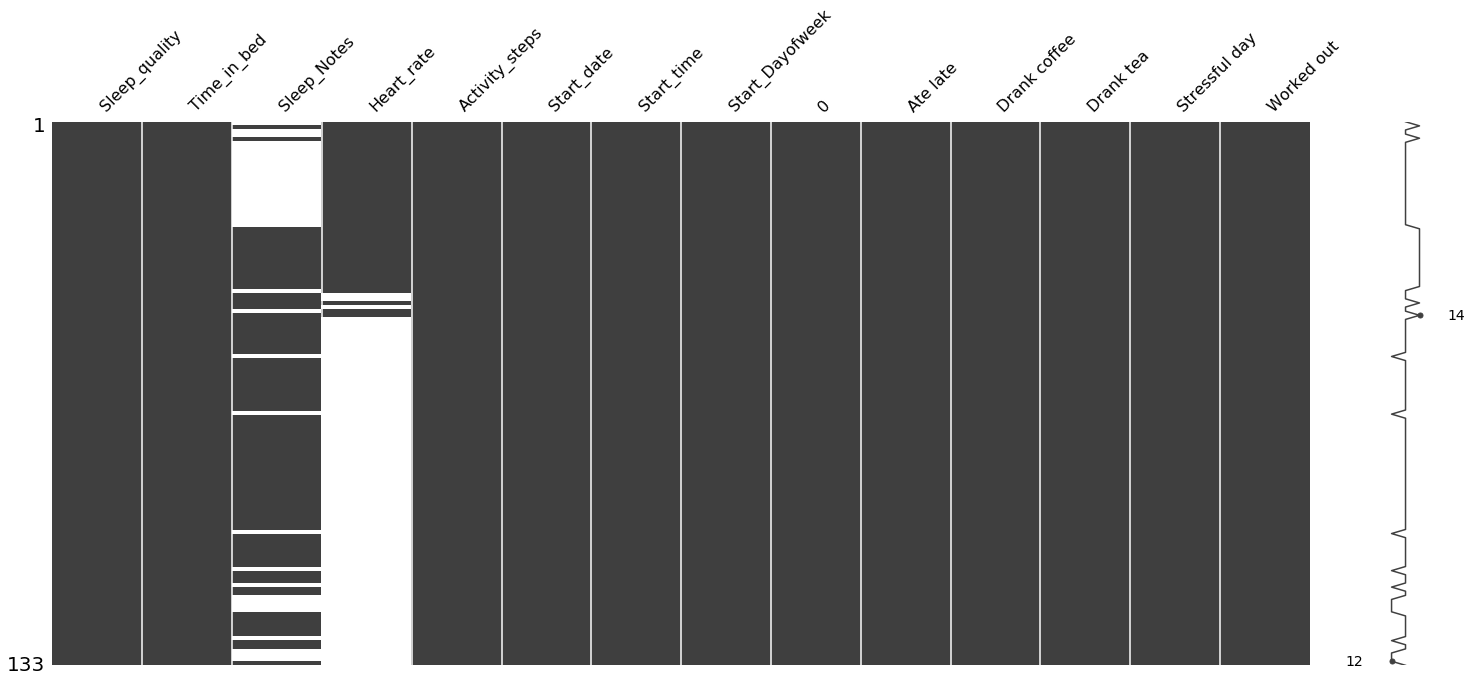

In [23]:
# assessing missing values in the full dataframe

msno.matrix(df_full);

In [24]:
# removing the certain columns since their entries are not informative; also removing 0 column 

df_full= df_full.drop([ '0', 'Drank tea', 'Sleep_Notes', 'Heart_rate'], axis=1)             

In [25]:
df_full.head() 

,Sleep_quality,Time_in_bed,Activity_steps,Start_date,Start_time,Start_Dayofweek,Ate late,Drank coffee,Stressful day,Worked out
115,70,398,10583,2016-11-17,11,Thursday,0,0,0,0
116,73,429,16053,2016-11-18,10,Friday,0,0,1,0
117,80,459,8794,2016-11-19,11,Saturday,0,0,0,0
118,75,429,2622,2016-11-20,10,Sunday,0,0,0,0
119,88,499,11744,2016-11-21,9,Monday,0,0,1,0


In [26]:
# removing the spaces from the new column names

df_full.rename(
  columns={
    'Ate late' : 'Ate_late',
    'Drank coffee' : 'Drank_coffee',
    'Drank tea': 'Drank_tea',
    'Stressful day': 'Stressful_day',
    'Worked out': 'Worked_out'  
  },
  inplace=True
)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 115 to 269
Data columns (total 10 columns):
Sleep_quality      133 non-null int64
Time_in_bed        133 non-null int64
Activity_steps     133 non-null int64
Start_date         133 non-null datetime64[ns]
Start_time         133 non-null int64
Start_Dayofweek    133 non-null object
Ate_late           133 non-null int64
Drank_coffee       133 non-null int64
Stressful_day      133 non-null int64
Worked_out         133 non-null int64
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 11.4+ KB


In [27]:
# checking if stress column contains enough data for analysis

stress = df_full.Stressful_day

In [28]:
stress.value_counts().sort_index()   # looks ok

0    83
1    50
Name: Stressful_day, dtype: int64

In [29]:
# checking if coffee column contain enough data for analysis

coffee = df_full.Drank_coffee

In [30]:
coffee.value_counts().sort_index()   # looks ok

0    80
1    53
Name: Drank_coffee, dtype: int64

In [31]:
# checking if ate alte column contain enough data for analysis

food = df_full.Ate_late

In [32]:
food.value_counts().sort_index()   # small ammount of occurences can affect the regression

0    115
1     18
Name: Ate_late, dtype: int64

In [33]:
exercise = df_full['Worked_out']

In [34]:
exercise.value_counts().sort_index()

0    121
1     12
Name: Worked_out, dtype: int64

In [35]:
# checking mins and maxs

round(df_full.describe(), 2)

,Sleep_quality,Time_in_bed,Activity_steps,Start_time,Ate_late,Drank_coffee,Stressful_day,Worked_out
count,133.00,133.00,133.00,133.00,133.00,133.00,133.00,133.00
mean,73.05,419.17,9429.39,10.50,0.14,0.40,0.38,0.09
std,14.31,73.78,3630.93,1.31,0.34,0.49,0.49,0.29
min,27.00,226.00,1222.00,7.00,0.00,0.00,0.00,0.00
25%,64.00,366.00,7191.00,10.00,0.00,0.00,0.00,0.00
50%,74.00,417.00,9049.00,10.00,0.00,0.00,0.00,0.00
75%,83.00,474.00,11277.00,11.00,0.00,1.00,1.00,0.00
max,100.00,593.00,21892.00,14.00,1.00,1.00,1.00,1.00


In [122]:
df_full.to_csv('df_full.csv')